# Deploy and monitor a machine learning workflow for Image Classification

## Setting up this notebook

This notebook was developed using the following environment settings for optimal performance and compatibility:

1. The `Python 3` kernel
2. The `ml.t3.medium` Sagemaker notebook instance

## Data Staging

To address Scones Unlimited's image classification needs, we will use the open-source CIFAR-100 dataset. This dataset will serve as a proxy for the vehicle images we need to classify. The process will follow a standard ETL (Extract, Transform, Load) workflow:

1. Extract the data from a hosting service
2. Transform it into a usable shape and format
3. Load it into a production system


### 1. Extract the data from the hosting service

The initial step is to extract the CIFAR-100 dataset, which is publicly hosted by the University of Toronto. The following cell defines a function, extract_cifar_data, to download and save this data.
https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz 

In [1]:
import requests

def extract_cifar_data(url, filename="cifar.tar.gz"):
    """A function for extracting the CIFAR-100 dataset and storing it as a gzipped file
    
    Arguments:
    url      -- the URL where the dataset is hosted
    filename -- the full path where the dataset will be written
    
    """
    
    r = requests.get(url)
    with open(filename, "wb") as file_context:
        file_context.write(r.content)

    print(f"Successfully downloaded the file from {url} to {filename}")
    return

In [2]:
extract_cifar_data("https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz")     

Successfully downloaded the file from https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz to cifar.tar.gz


### 2. Transform the data into a usable shape and format

Clearly, distributing the data as a gzipped archive makes sense for the hosting service! It saves on bandwidth, storage, and it's a widely-used archive format. In fact, it's so widely used that the Python community ships a utility for working with them, `tarfile`, as part of its Standard Library.

In [3]:
import tarfile
import pickle


print("Decompressing the downloaded CIFAR archive")
with tarfile.open("cifar.tar.gz", "r:gz") as tar:
    tar.extractall()
print("Decompression complete. The 'cifar-100-python' folder has been created.")


print("Loading dataset files into memory")
with open("./cifar-100-python/meta", "rb") as f:
    dataset_meta = pickle.load(f, encoding='bytes')
with open("./cifar-100-python/test", "rb") as f:
    dataset_test = pickle.load(f, encoding='bytes')
with open("./cifar-100-python/train", "rb") as f:
    dataset_train = pickle.load(f, encoding='bytes')
print("Dataset files loaded successfully.")

Decompressing the downloaded CIFAR archive


/tmp/ipykernel_172/2395096522.py:7: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall()


Decompression complete. The 'cifar-100-python' folder has been created.
Loading dataset files into memory
Dataset files loaded successfully.


In [4]:
dataset_train.keys()

dict_keys([b'filenames', b'batch_label', b'fine_labels', b'coarse_labels', b'data'])

Looking at the raw data, the b'data' key holds our images as a flattened array of 3,072 integers. Since each image is 32×32 pixels with three color channels (red, green, and blue), we need to reshape this into a proper 32x32x3 array. Before we process the whole dataset, let's do a quick gut-check on a single image to make sure our reshaping logic is solid. The following code shows how we can take that raw data, turn it into a correctly formatted image, and save it as a PNG file to verify the process.

In [5]:
import numpy as np

# Each 1024 in a row is a channel (red, green, then blue)
row = dataset_train[b'data'][0]
red, green, blue = row[0:1024], row[1024:2048], row[2048:]

# Each 32 items in the channel are a row in the 32x32 image
red = red.reshape(32,32)
green = green.reshape(32,32)
blue = blue.reshape(32,32)

# Combine the channels into a 32x32x3 image!
combined = np.dstack((red,green,blue))

For a more concise version:

In [6]:
# All in one:
test_image = np.dstack((
    row[0:1024].reshape(32,32),
    row[1024:2048].reshape(32,32),
    row[2048:].reshape(32,32)
))

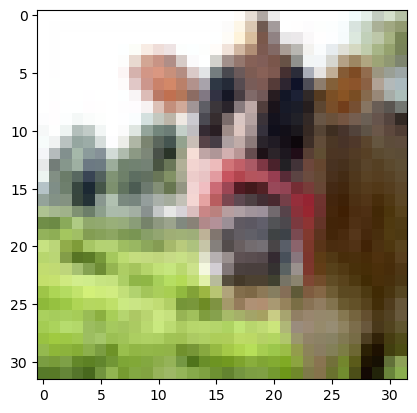

In [7]:
import matplotlib.pyplot as plt
plt.imshow(test_image);

Now that we have successfully reshaped and visualized a single image, it's crucial to verify the associated metadata. The dataset_train object contains a b'fine_labels' key, which holds the integer label for each image. We can use this label to cross-reference with the b'fine_label_names' in dataset_meta to ensure data integrity.

The following code demonstrates how we can retrieve the fine-grained label for a given image, use that label to find the corresponding class name, and then verify the consistency of the b'filenames' key. This process is essential for ensuring that our model will be trained on the correct data.

In [8]:
# Grab the label for the first image
label_index = dataset_train[b'fine_labels'][0]

# Check the corresponding label name in the metadata
label_name = dataset_meta[b'fine_label_names'][label_index]
print(f"The label name for the first image is: {label_name.decode('utf-8')}")

# Check the filename for consistency
filename = dataset_train[b'filenames'][0]
print(f"The filename for the first image is: {filename.decode('utf-8')}")

The label name for the first image is: cattle
The filename for the first image is: bos_taurus_s_000507.png


In [ ]:
# plt.imsave("file.png", test_image)

Now that we have confirmed our image reshaping and saving process is functional, the next step is to prepare the full dataset. Our goal for Scones Unlimited is to build a model that can automatically identify bicycles and motorcycles to optimize delivery routes.

To achieve this, we will filter the dataset to include only images of bicycles and motorcycles. The first step is to identify the integer labels for these two classes from the dataset metadata.

In [9]:
import pandas as pd

# Todo: Filter the dataset_train and dataset_meta objects to find the label numbers for Bicycle and Motorcycles
# decode into str
decoded_fine_labels = [label.decode('utf-8') for label in dataset_meta[b'fine_label_names']]

# create df
labels_df = pd.DataFrame(decoded_fine_labels, columns=['label_name'])
# filter df
bicycles_and_motorcycles = labels_df[labels_df['label_name'].isin(['bicycle', 'motorcycle'])]

print(bicycles_and_motorcycles)

    label_name
8      bicycle
48  motorcycle


 The following code constructs the training and testing DataFrames and filters out all rows that do not have a label of 8 (bicycle) or 48 (motorcycle).

In [10]:
#Construct the dataframe
df_train = pd.DataFrame({
    "filenames": dataset_train[b'filenames'],
    "labels": dataset_train[b'fine_labels'],
    "row": range(len(dataset_train[b'filenames']))
})

# Drop all rows from df_train where label is not 8 or 48
df_train = df_train[df_train['labels'].isin([8, 48])]

# Decode df_train.filenames so they are regular strings
df_train["filenames"] = df_train["filenames"].apply(
    lambda x: x.decode("utf-8")
)


df_test = pd.DataFrame({
    "filenames": dataset_test[b'filenames'],
    "labels": dataset_test[b'fine_labels'],
    "row": range(len(dataset_test[b'filenames']))
})

# Drop all rows from df_test where label is not 8 or 48
df_test = df_test[df_test['labels'].isin([8, 48])]

# Decode df_test.filenames so they are regular strings
df_test["filenames"] = df_test["filenames"].apply(
    lambda x: x.decode("utf-8")
)

print(f"Filtered training set size: {len(df_train)} rows")
print(f"Filtered test set size: {len(df_test)} rows")

Filtered training set size: 1000 rows
Filtered test set size: 200 rows


Now that the data is filtered for just our classes, we can save all our images.

In [11]:
!mkdir ./train
!mkdir ./test

We have all the components needed to save our filtered images. We will now compose a function, save_images, that takes the image data, reshapes it, and saves it to a specified directory. This function will be used to process all images in both the ./train and ./test directories.

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import os

def save_images(row, path, dataset):
    '''
    args:
    - row - pandas series containing the images row index and filename
    - path - dir where images should be saved
    - dataset - dict containing the original image data
    '''
    #Grab the image data in row-major form
    img = dataset[b'data'][row['row']]
    
    # Consolidated stacking/reshaping from earlier
    target = np.dstack((
        img[0:1024].reshape(32,32),
        img[1024:2048].reshape(32,32),
        img[2048:].reshape(32,32)
    ))
    
    # Save the image
    full_path = os.path.join(path, row['filenames'])
    plt.imsave(full_path, target)
    
    # Return any signal data you want for debugging
    return target

## TODO: save ALL images using the save_images function
print('Saving training images')
for index, row in df_train.iterrows():
    save_images(row, './train', dataset_train)
print('Training images saved')

print('Saving test images')
for index, row in df_test.iterrows():
    save_images(row, './test', dataset_test)
print('Test images saved')

Saving training images
Training images saved
Saving test images
Test images saved


### 3. Load the data

Now we can load the data into S3.

In [13]:
import sagemaker

sagemaker_session = sagemaker.Session()

bucket = sagemaker_session.default_bucket()
print("Default Bucket: {}".format(bucket))

region = sagemaker_session.boto_region_name
print("AWS Region: {}".format(region))

role = sagemaker.get_execution_role()
print("RoleArn: {}".format(role))

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
Default Bucket: sagemaker-us-east-1-463470970194
AWS Region: us-east-1
RoleArn: arn:aws:iam::463470970194:role/service-role/AmazonSageMaker-ExecutionRole-20250828T121007


In [14]:
import os

os.environ["DEFAULT_S3_BUCKET"] = bucket
!aws s3 sync ./train s3://${DEFAULT_S3_BUCKET}/train/
!aws s3 sync ./test s3://${DEFAULT_S3_BUCKET}/test/

upload: train/bicycle_s_000017.png to s3://sagemaker-us-east-1-463470970194/train/bicycle_s_000017.png
upload: train/bicycle_s_000035.png to s3://sagemaker-us-east-1-463470970194/train/bicycle_s_000035.png
upload: train/bicycle_s_000021.png to s3://sagemaker-us-east-1-463470970194/train/bicycle_s_000021.png
upload: train/bicycle_s_000038.png to s3://sagemaker-us-east-1-463470970194/train/bicycle_s_000038.png
upload: train/bicycle_s_000099.png to s3://sagemaker-us-east-1-463470970194/train/bicycle_s_000099.png
upload: train/bicycle_s_000137.png to s3://sagemaker-us-east-1-463470970194/train/bicycle_s_000137.png
upload: train/bicycle_s_000147.png to s3://sagemaker-us-east-1-463470970194/train/bicycle_s_000147.png
upload: train/bicycle_s_000156.png to s3://sagemaker-us-east-1-463470970194/train/bicycle_s_000156.png
upload: train/bicycle_s_000149.png to s3://sagemaker-us-east-1-463470970194/train/bicycle_s_000149.png
upload: train/bicycle_s_000039.png to s3://sagemaker-us-east-1-4634709701

## Model Training

For our image classification model, SageMaker requires metadata in the form of `TSV files`. These files will map the filepaths of our images to their corresponding labels. We will generate these metadata files using the pandas DataFrames we created earlier, which contain all the necessary information. The to_metadata_file function below will handle the necessary data formatting and save the metadata as train.lst and test.lst, which is the format expected by the SageMaker Image Classification algorithm.

In [15]:
def to_metadata_file(df, prefix):
    df["s3_path"] = df["filenames"]
    df["labels"] = df["labels"].apply(lambda x: 0 if x==8 else 1)
    return df[["row", "labels", "s3_path"]].to_csv(
        f"{prefix}.lst", sep="\t", index=False, header=False
    )
    
to_metadata_file(df_train.copy(), "train")
to_metadata_file(df_test.copy(), "test")

Upload our manifest files:

In [16]:
import boto3

# Upload files
boto3.Session().resource('s3').Bucket(
    bucket).Object('train.lst').upload_file('./train.lst')
boto3.Session().resource('s3').Bucket(
    bucket).Object('test.lst').upload_file('./test.lst')

Using the `bucket` and `region` info we can get the latest prebuilt container to run our training job, and define an output location on our s3 bucket for the model.

In [17]:
from sagemaker import image_uris

algo_image = image_uris.retrieve(framework='image-classification', region=region)
s3_output_location = f"s3://{bucket}/models/image_model"

print(f"Algorithm image URI: {algo_image}")
print(f"S3 output location: {s3_output_location}")

Algorithm image URI: 811284229777.dkr.ecr.us-east-1.amazonaws.com/image-classification:1
S3 output location: s3://sagemaker-us-east-1-463470970194/models/image_model


Creating an estimator `img_classifier_model`

In [18]:
img_classifier_model=sagemaker.estimator.Estimator(
    image_uri=algo_image,
    role=role,
    instance_count=1,
    instance_type='ml.p3.2xlarge',
    output_path=s3_output_location,
    sagemaker_session=sagemaker.Session()
)

Setting hyperparameters and defining the inputs for our model:

In [19]:
img_classifier_model.set_hyperparameters(
    image_shape='3,32,32',
    num_classes=2,
    num_training_samples=1000,
    # num_epochs=20,
    # learning_rate=0.01
)

The `image-classification` image uses four input channels with very specific input parameters.

In [20]:
from sagemaker.session import TrainingInput

model_inputs = {
        "train": sagemaker.inputs.TrainingInput(
            s3_data=f"s3://{bucket}/train/",
            content_type="application/x-image"
        ),
        "validation": sagemaker.inputs.TrainingInput(
            s3_data=f"s3://{bucket}/test/",
            content_type="application/x-image"
        ),
        "train_lst": sagemaker.inputs.TrainingInput(
            s3_data=f"s3://{bucket}/train.lst",
            content_type="application/x-image"
        ),
        "validation_lst": sagemaker.inputs.TrainingInput(
            s3_data=f"s3://{bucket}/test.lst",
            content_type="application/x-image"
        )
}

Great, now we can train the model using the model_inputs.

In [21]:
print('Starting the model training job...')

img_classifier_model.fit(
    inputs=model_inputs,
    wait=True
)

print('Model training complete')

INFO:sagemaker:Creating training-job with name: image-classification-2025-08-28-10-24-45-587


Starting the model training job...
2025-08-28 10:24:48 Starting - Starting the training job
2025-08-28 10:24:48 Pending - Training job waiting for capacity.........
2025-08-28 10:25:54 Pending - Preparing the instances for training...
2025-08-28 10:26:45 Downloading - Downloading the training image...............
2025-08-28 10:29:07 Training - Training image download completed. Training in progress....Docker entrypoint called with argument(s): train
Running default environment configuration script
Nvidia gpu devices, drivers and cuda toolkit versions (only available on hosts with GPU):
Thu Aug 28 10:29:34 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.172.08             Driver Version: 570.172.08     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  

Validation accuracy is around 80%.

### Getting ready to deploy

To begin with, let's configure Model Monitor to track our deployment. We'll define a `DataCaptureConfig` below:`

In [22]:
from sagemaker.model_monitor import DataCaptureConfig

data_capture_config = DataCaptureConfig(
    enable_capture=True,
    sampling_percentage=100,
    destination_s3_uri=f"s3://{bucket}/data_capture",
    csv_content_types=['text/csv'],
    json_content_types=['application/json']
)

In [23]:
deployment = img_classifier_model.deploy(
    initial_instance_count=1,
    instance_type='ml.m5.xlarge',
    data_capture_config=data_capture_config
    )

endpoint = deployment.endpoint_name
print(endpoint)

INFO:sagemaker:Creating model with name: image-classification-2025-08-28-10-49-35-302
INFO:sagemaker:Creating endpoint-config with name image-classification-2025-08-28-10-49-35-302
INFO:sagemaker:Creating endpoint with name image-classification-2025-08-28-10-49-35-302


---------!image-classification-2025-08-28-10-49-35-302


instantiate a Predictor:

In [25]:
predictor = deployment

In the code snippet below we are going to prepare one of the saved images for prediction.

In [28]:
from sagemaker.serializers import IdentitySerializer
import base64

predictor.serializer = IdentitySerializer("image/png")
with open("./test/bicycle_s_000030.png", "rb") as f:
    payload = f.read()

    
inference = predictor.predict(payload)

Based on the output from the deployed model, the inference object provides a pair of values. The first value is the predicted probability that the image is a bicycle (label 0), and the second is the probability that it is a motorcycle (label 1).

In [29]:
print(inference)

b'[0.39815643429756165, 0.6018435955047607]'


### Lambdas and Step Function Workflow


#### The Step Function Workflow Architecture
Our serverless workflow is a three-step assembly line orchestrated by AWS Step Functions. Each Lambda function in the sequence performs a single, specialized task on the data before passing it to the next step.

- serializeImageData: This function retrieves an image from our S3 bucket, reads the data, and encodes it into a Base64 string.

- classifier: This function takes the encoded image data, sends it to our deployed SageMaker endpoint for a prediction, and adds the resulting confidence scores to the data.

- filterInferences: The final function applies our business logic by checking if the model's highest confidence score meets a predefined threshold. If the score is too low, the workflow stops with an error.

I created and deployed three separate Lambda functions for each step of the pipeline. I configured each one with the necessary permissions to read from S3 and interact with the SageMaker endpoint. After writing and testing the code for each function, I used the Step Functions visual editor to connect them in the correct order.

I made sure to properly handle the data passing between each step, and for the last function, I intentionally let it “fail loudly” with an error if the confidence score was too low.

To show the working pipeline and its components, I've included screenshots of the Lambda functions and the completed Step Functions workflow in action.

You can find the screenshots of my AWS setup here: [Lambda Functions](./screenshots/lambda), [Step Functions](./screenshots/step-functions)


### Testing and Evaluation

I tested the Step Functions workflow by invoking it several times using data from the ./test folder. This process successfully confirmed that the workflow both succeeds and fails as expected, based on the filterInferences step. Additionally, these invocations generated data and inference recordings for the SageMaker Model Monitor, which I can now use for visualization.

In [51]:
import random
import boto3
import json


def generate_test_case():
    # Setup s3 in boto3
    s3 = boto3.resource('s3')
    
    # Randomly pick from sfn or test folders in our bucket
    objects = s3.Bucket(bucket).objects.filter(Prefix="test")
    
    # Grab any random object key from that folder!
    obj = random.choice([x.key for x in objects])
    
    return json.dumps({
        "image_data": "",
        "s3_bucket": bucket,
        "s3_key": obj
    })
generate_test_case()

'{"image_data": "", "s3_bucket": "sagemaker-us-east-1-463470970194", "s3_key": "test/motorcycle_s_000963.png"}'

In [52]:
from sagemaker.s3 import S3Downloader


data_path = f"s3://{bucket}/data_capture/{endpoint}/AllTraffic/2025/08/28/13" # needs to be replaced

S3Downloader.download(data_path, "captured_data")

# Feel free to repeat this multiple times and pull in more data

['captured_data/08-47-369-e7daafef-154e-443d-8cdd-0a4ffe086515.jsonl',
 'captured_data/10-04-274-e756e2f3-0823-4af7-867b-383e3c338908.jsonl',
 'captured_data/11-05-900-fa248169-a7d6-406f-9008-e6eed3ff5051.jsonl',
 'captured_data/12-29-925-e08eb5b6-a0b4-4b6b-b0b5-83cc4554580f.jsonl']

In [34]:
!pip install jsonlines
import jsonlines

Now we can extract the data from each of the source files:

In [55]:
import os

# List the file names we downloaded
file_handles = os.listdir("./captured_data")

# Dump all the data into an array
json_data = []
for jsonl in file_handles:
    with jsonlines.open(f"./captured_data/{jsonl}") as f:
        json_data.append(f.read())

The data should now be a list of dictionaries, with significant nesting.

In [56]:
# Define how we'll get our data
def simple_getter(obj):
    inferences = obj["captureData"]["endpointOutput"]["data"]
    timestamp = obj["eventMetadata"]["inferenceTime"]
    return json.loads(inferences), timestamp

simple_getter(json_data[0])

([0.979941189289093, 0.020058831200003624], '2025-08-28T12:00:43Z')

Visualization example

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


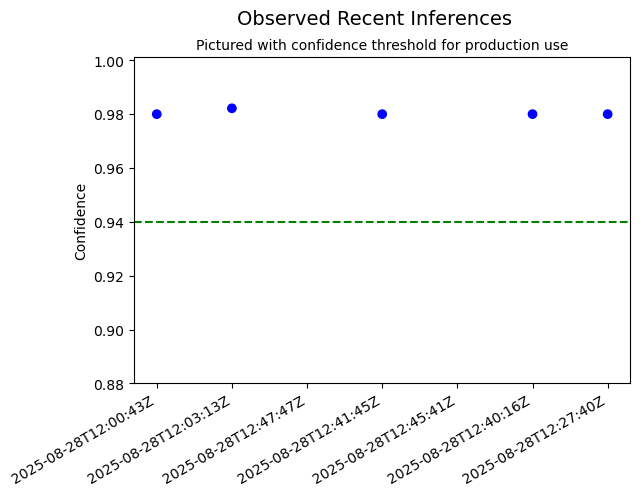

In [37]:
# Populate the data for the x and y axis
x = []
y = []
for obj in json_data:
    inference, timestamp = simple_getter(obj)
    
    y.append(max(inference))
    x.append(timestamp)

# Todo: here is an visualization example, take some time to build another visual that helps monitor the result
# Plot the data
plt.scatter(x, y, c=['r' if k<.94 else 'b' for k in y ])
plt.axhline(y=0.94, color='g', linestyle='--')
plt.ylim(bottom=.88)

# Add labels
plt.ylabel("Confidence")
plt.suptitle("Observed Recent Inferences", size=14)
plt.title("Pictured with confidence threshold for production use", size=10)

# Give it some pizzaz!
plt.style.use("Solarize_Light2")
plt.gcf().autofmt_xdate()

### Todo: build your own visualization


Filtered scatter plot created successfully.


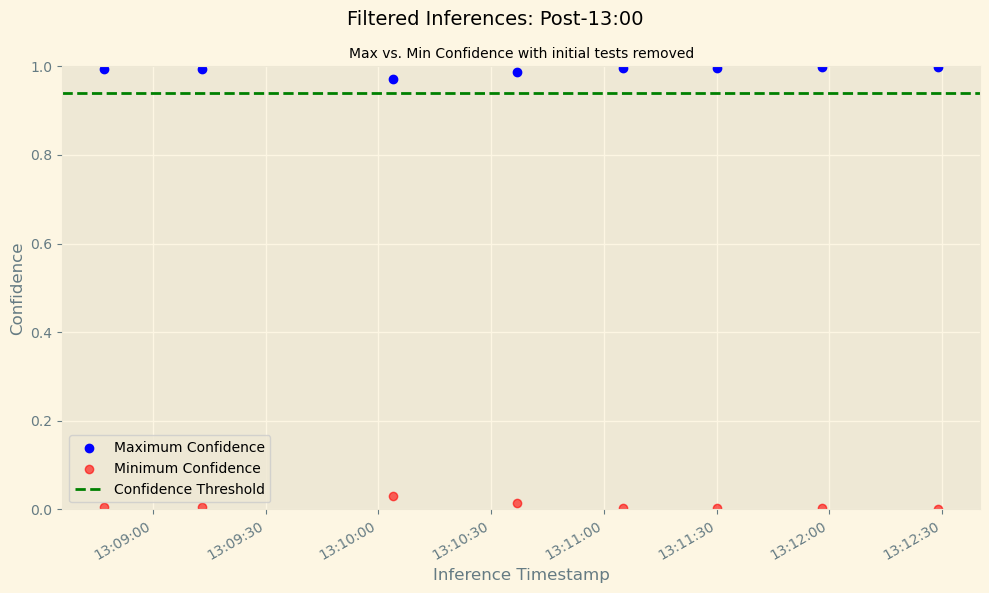

In [61]:
import os
import json
import matplotlib.pyplot as plt
from datetime import datetime
import jsonlines


try:
    file_handles = os.listdir("./captured_data")
except FileNotFoundError:
    print("The 'captured_data' directory was not found. Please ensure you have downloaded the data from S3 first.")
    exit()

all_inferences_data = []
for jsonl_file in file_handles:
    full_path = os.path.join("./captured_data", jsonl_file)
    with open(full_path, 'r') as f:
        for line in f:
            if line.strip():  # Skip empty lines
                all_inferences_data.append(json.loads(line))

# Filter the data to only include records after the 13:00 hour
filtered_inferences = []
for obj in all_inferences_data:
    timestamp_str = obj["eventMetadata"]["inferenceTime"]
    dt_object = datetime.strptime(timestamp_str, "%Y-%m-%dT%H:%M:%SZ")
    
    # Check if the hour is 13 or later (0-23 hour format)
    if dt_object.hour >= 13:
        filtered_inferences.append(obj)

# Populate the data for the x and y axis with the filtered data
timestamps = []
max_inferences = []
min_inferences = []

for obj in filtered_inferences:
    inferences = json.loads(obj["captureData"]["endpointOutput"]["data"])
    timestamp_str = obj["eventMetadata"]["inferenceTime"]
    
    dt_object = datetime.strptime(timestamp_str, "%Y-%m-%dT%H:%M:%SZ")
    timestamps.append(dt_object)
    
    max_inferences.append(max(inferences))
    min_inferences.append(min(inferences))

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(timestamps, max_inferences, c='blue', label='Maximum Confidence')
plt.scatter(timestamps, min_inferences, c='red', alpha=0.6, label='Minimum Confidence')
plt.axhline(y=0.94, color='g', linestyle='--', label='Confidence Threshold')
plt.ylabel("Confidence")
plt.xlabel("Inference Timestamp")
plt.suptitle("Filtered Inferences: Post-13:00", size=14)
plt.title("Max vs. Min Confidence with initial tests removed", size=10)
plt.legend()
plt.ylim(bottom=0.0, top=1.0)
plt.gcf().autofmt_xdate()
plt.tight_layout()

# Save the plot
plt.savefig("filtered_max_min_confidence_scatter_plot.png")

print("Filtered scatter plot created successfully.")

To analyze the model's performance, I created two scatter plots from the data captured by SageMaker Model Monitor. The code processes JSON data to extract timestamps and the highest and lowest confidence scores for each prediction.

The first plot visualizes all bicycle predictions, showing the model's max confidence (for the correct class) versus its min confidence (for the other class) over time.

The second plot does the same for all motorcycle predictions. Both graphs include a dashed green line at 0.94, representing the confidence threshold set in my Step Functions workflow. This visualization helps to quickly assess the model's certainty and consistency.

Two separate scatter plots for bicycles and motorcycles created successfully.


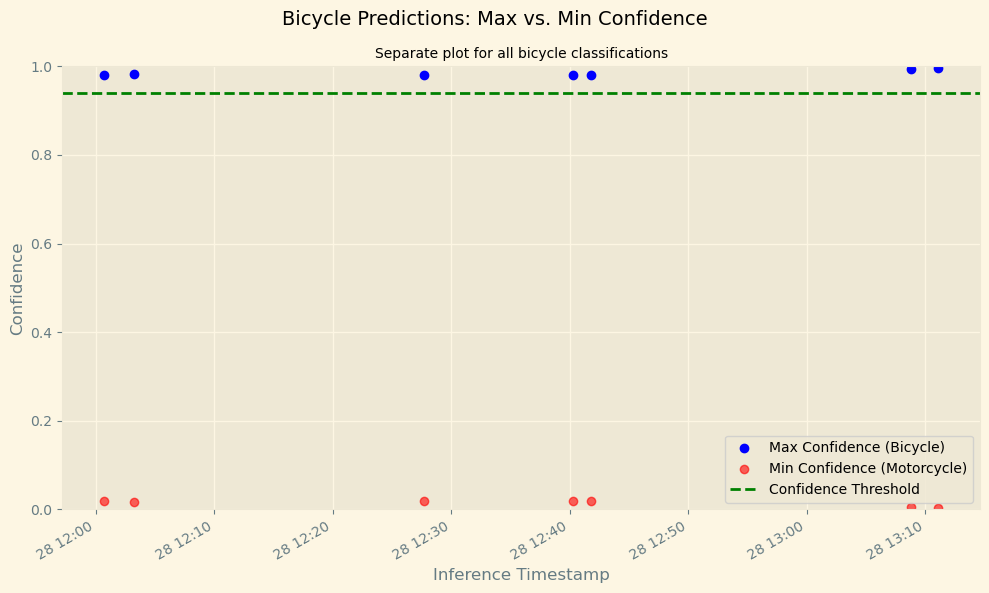

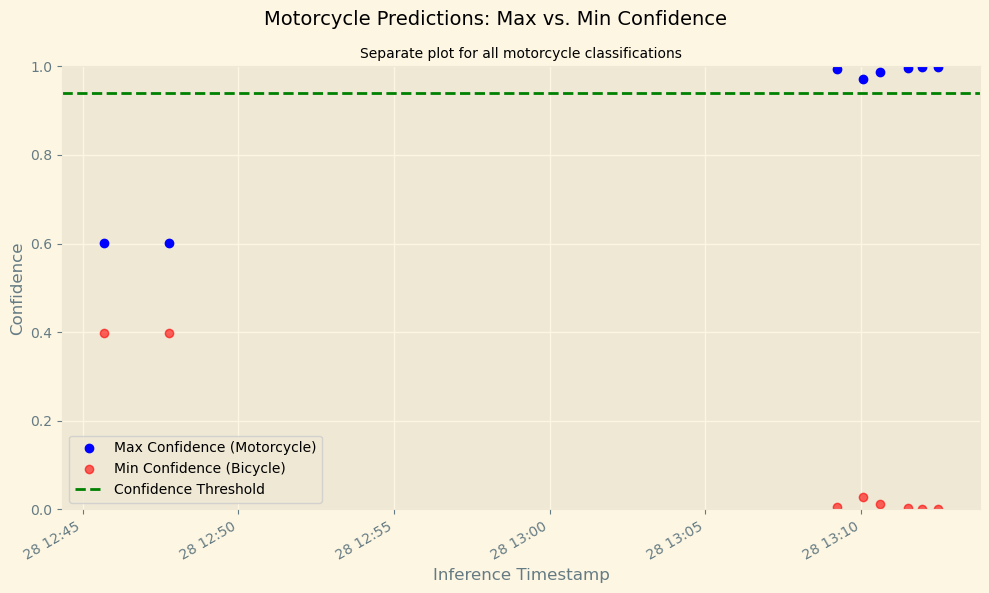

In [62]:
import os
import json
import matplotlib.pyplot as plt
from datetime import datetime
import jsonlines

try:
    file_handles = os.listdir("./captured_data")
except FileNotFoundError:
    print("The 'captured_data' directory was not found. Please ensure you have downloaded the data from S3 first.")
    exit()

# Store data for each class in separate lists
timestamps_bike = []
max_inferences_bike = []
min_inferences_bike = []

timestamps_motorbike = []
max_inferences_motorbike = []
min_inferences_motorbike = []

for jsonl_file in file_handles:
    full_path = os.path.join("./captured_data", jsonl_file)
    with open(full_path, 'r') as f:
        for line in f:
            if line.strip():
                obj = json.loads(line)
                inferences = json.loads(obj["captureData"]["endpointOutput"]["data"])
                timestamp_str = obj["eventMetadata"]["inferenceTime"]

                # Find the index of the highest confidence score
                predicted_class_index = inferences.index(max(inferences))

                # Parse the timestamp
                dt_object = datetime.strptime(timestamp_str, "%Y-%m-%dT%H:%M:%SZ")

                if predicted_class_index == 0:  # Class 0 is 'bicycle'
                    timestamps_bike.append(dt_object)
                    max_inferences_bike.append(max(inferences))
                    min_inferences_bike.append(min(inferences))
                elif predicted_class_index == 1:  # Class 1 is 'motorcycle'
                    timestamps_motorbike.append(dt_object)
                    max_inferences_motorbike.append(max(inferences))
                    min_inferences_motorbike.append(min(inferences))

# Create the first plot for Bicycles
plt.figure(figsize=(10, 6))
plt.scatter(timestamps_bike, max_inferences_bike, c='blue', label='Max Confidence (Bicycle)')
plt.scatter(timestamps_bike, min_inferences_bike, c='red', alpha=0.6, label='Min Confidence (Motorcycle)')
plt.axhline(y=0.94, color='g', linestyle='--', label='Confidence Threshold')
plt.ylabel("Confidence")
plt.xlabel("Inference Timestamp")
plt.suptitle("Bicycle Predictions: Max vs. Min Confidence", size=14)
plt.title("Separate plot for all bicycle classifications", size=10)
plt.legend()
plt.ylim(bottom=0.0, top=1.0)
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.savefig("bicycle_predictions.png")

# Create the second plot for Motorcycles
plt.figure(figsize=(10, 6))
plt.scatter(timestamps_motorbike, max_inferences_motorbike, c='blue', label='Max Confidence (Motorcycle)')
plt.scatter(timestamps_motorbike, min_inferences_motorbike, c='red', alpha=0.6, label='Min Confidence (Bicycle)')
plt.axhline(y=0.94, color='g', linestyle='--', label='Confidence Threshold')
plt.ylabel("Confidence")
plt.xlabel("Inference Timestamp")
plt.suptitle("Motorcycle Predictions: Max vs. Min Confidence", size=14)
plt.title("Separate plot for all motorcycle classifications", size=10)
plt.legend()
plt.ylim(bottom=0.0, top=1.0)
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.savefig("motorcycle_predictions.png")

print("Two separate scatter plots for bicycles and motorcycles created successfully.")

### Conclusion
This project successfully demonstrates a complete end-to-end machine learning workflow on AWS. I was able to build a serverless pipeline that extracts, transforms, and loads data, trains an image classification model on SageMaker, and then uses a Step Functions workflow with Lambda functions for real-time inference. The visualization of the model's output provides a clear and effective way to monitor its performance.

One of the next steps in this project is to integrate SNS into the workflow for automated alerts. I spent some time trying to set this up, but encountered an error that required further troubleshooting. I have decided to address this in a future iteration of the project to ensure the core pipeline is fully documented and functional. Overall, this project has been a great learning experience in building and monitoring a robust machine learning solution on AWS.